# QUANTITATIVE METHODS - ASSIGNMENT 1 

Does the allocation of funds help reduce the cases of obesity

Data source: https://data.london.gov.uk/dataset/prevalence-childhood-obesity-borough

#### I am going to use a Multiple Regression model to understand on what conditions did the budget spend had more impact in reducing the cases of obesity. 

In [42]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import numpy as np

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

In [89]:
obesity_cases = pd.read_csv('Data_final.csv')

In [90]:
obesity_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   local_authority_area  152 non-null    object 
 1   2008_cases_total      152 non-null    int64  
 2   2018_cases_total      152 non-null    int64  
 3   2008_pop_total        152 non-null    int64  
 4   2018_pop_total        152 non-null    int64  
 5   incr_cases            152 non-null    float64
 6   avg_population        152 non-null    float64
 7   total_budget          152 non-null    float64
 8   clean_air             152 non-null    float64
 9   clean_environ         152 non-null    float64
 10  health_training       152 non-null    float64
 11  school_awareness      152 non-null    float64
 12  media_awareness       152 non-null    float64
 13  sub_counselling       152 non-null    float64
 14  region                152 non-null    object 
 15  local_authority_type  1

In [91]:
obesity_cases.head()

,local_authority_area,2008_cases_total,2018_cases_total,2008_pop_total,2018_pop_total,incr_cases,avg_population,total_budget,clean_air,clean_environ,health_training,school_awareness,media_awareness,sub_counselling,region,local_authority_type
0,Barking and Dagenham,593,763,172684,181779,0.0008,"177,231.5000",0.7843,0.1185,0.1241,0.1016,0.2313,0.1016,0.1072,London,london_borough
1,Barnet,539,773,340435,355955,0.0006,"348,195.0000",0.6318,0.1436,0.0488,0.0661,0.2125,0.0862,0.0747,London,london_borough
2,Barnsley,360,527,226755,257883,0.0005,"242,319.0000",0.6603,0.1692,0.1857,0.0206,0.1073,0.1197,0.0578,Yorkshire and the Humber,metropolitan_borough
3,Bath and North East Somerset,456,494,178625,189334,0.0001,"183,979.5000",0.8751,0.1794,0.2283,0.1033,0.2718,0.0544,0.0380,South West,unitary_authority
4,Bedford,311,367,158185,170463,0.0002,"164,324.0000",0.7911,0.2252,0.3164,0.1035,0.0487,0.0183,0.0791,East of England,unitary_authority


In [92]:
obesity_cases_final = obesity_cases.drop(['local_authority_area', '2008_cases_total', '2018_cases_total', '2008_pop_total', '2018_pop_total', 'avg_population', 'region', 'local_authority_type'], axis=1)

# double check the result
obesity_cases_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   incr_cases        152 non-null    float64
 1   total_budget      152 non-null    float64
 2   clean_air         152 non-null    float64
 3   clean_environ     152 non-null    float64
 4   health_training   152 non-null    float64
 5   school_awareness  152 non-null    float64
 6   media_awareness   152 non-null    float64
 7   sub_counselling   152 non-null    float64
dtypes: float64(8)
memory usage: 9.6 KB


In [118]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [94]:
obesity_cases_final.columns

Index(['incr_cases', 'total_budget', 'clean_air', 'clean_environ',
       'health_training', 'school_awareness', 'media_awareness',
       'sub_counselling'],
      dtype='object')

In [95]:
# using VIF on the bike_rental dataset
df_predictors_selected_VIF = drop_column_using_vif_(obesity_cases_final.drop('incr_cases', axis=1))
# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF.columns)

Dropping: total_budget
The columns remaining after VIF selection are:
Index(['clean_air', 'clean_environ', 'health_training', 'school_awareness',
       'media_awareness', 'sub_counselling'],
      dtype='object')


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [96]:
df_predictors_selected_VIF

,clean_air,clean_environ,health_training,school_awareness,media_awareness,sub_counselling
0,0.1185,0.1241,0.1016,0.2313,0.1016,0.1072
1,0.1436,0.0488,0.0661,0.2125,0.0862,0.0747
2,0.1692,0.1857,0.0206,0.1073,0.1197,0.0578
3,0.1794,0.2283,0.1033,0.2718,0.0544,0.0380
4,0.2252,0.3164,0.1035,0.0487,0.0183,0.0791
5,0.3048,0.1143,0.0593,0.2709,0.0635,0.0296
6,0.0606,0.2575,0.1231,0.1193,0.1325,0.0937
7,0.1062,0.1132,0.0920,0.1486,0.1274,0.0566
8,0.1660,0.1314,0.0623,0.1937,0.0692,0.0623
9,0.1997,0.2469,0.0399,0.0908,0.1126,0.0399


In [97]:
model_obesity_cases = sm.OLS(endog=obesity_cases_final[['incr_cases']], exog=sm.add_constant(df_predictors_selected_VIF)).fit()
model_obesity_cases.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             incr_cases   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     4.668
Date:                Mon, 15 Nov 2021   Prob (F-statistic):           0.000227
Time:                        00:13:58   Log-Likelihood:                 1057.7
No. Observations:                 152   AIC:                            -2101.
Df Residuals:                     145   BIC:                            -2080.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0002    7.2e-05      2.173      0.031    1.42e-05       0.000
clean_air        -7.746e-05      0.000     -0.329      0.743      -0.001       0.000
clean_environ        0.0004      0.000      1.686      0.094   -6.62e-05       0.001
health_training      0.0002      0.001      0.335      0.738      -0.001       0.001
school_awareness    -0.0005      0.000     -3.027      0.003      -0.001      -0.000
media_awareness      0.0016      0.000      3.398      0.001       0.001       0.002
sub_counselling      0.0011      0.001      1.413      0.160      -0.000       0.003
==============================================================================
Omnibus:                        2.138   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.343   Jarque-Bera (JB):                2.026
Skew:                           0.201   Prob(JB):                        0.363
Kurtosis:                       2.602   Cond. No.                         42.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

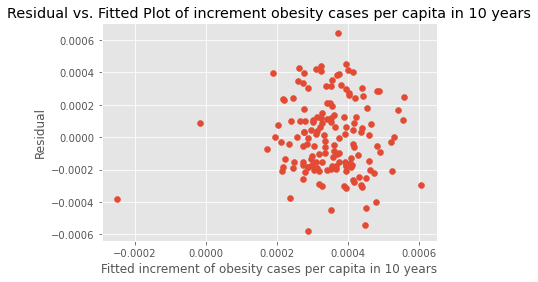

In [98]:
#Residual Analysis

# plot 
plt.scatter(model_obesity_cases.fittedvalues, model_obesity_cases.resid)
# adding title and labels
plt.xlabel('Fitted increment of obesity cases per capita in 10 years')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of increment obesity cases per capita in 10 years')
plt.show()

## Lets get rid of the outliers


In [99]:
obesity_cases_outliers = pd.read_csv('Data_final_outliers.csv')

In [100]:
obesity_cases_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   local_authority_area  150 non-null    object 
 1   2008_cases_total      150 non-null    int64  
 2   2018_cases_total      150 non-null    int64  
 3   2008_pop_total        150 non-null    int64  
 4   2018_pop_total        150 non-null    int64  
 5   incr_cases            150 non-null    float64
 6   avg_population        150 non-null    float64
 7   total_budget          150 non-null    float64
 8   clean_air             150 non-null    float64
 9   clean_environ         150 non-null    float64
 10  health_training       150 non-null    float64
 11  school_awareness      150 non-null    float64
 12  media_awareness       150 non-null    float64
 13  sub_counselling       150 non-null    float64
 14  region                150 non-null    object 
 15  local_authority_type  1

In [101]:
obesity_cases_outliers.head()

,local_authority_area,2008_cases_total,2018_cases_total,2008_pop_total,2018_pop_total,incr_cases,avg_population,total_budget,clean_air,clean_environ,health_training,school_awareness,media_awareness,sub_counselling,region,local_authority_type
0,Barking and Dagenham,593,763,172684,181779,0.0008,"177,231.5000",0.7843,0.1185,0.1241,0.1016,0.2313,0.1016,0.1072,London,london_borough
1,Barnet,539,773,340435,355955,0.0006,"348,195.0000",0.6318,0.1436,0.0488,0.0661,0.2125,0.0862,0.0747,London,london_borough
2,Barnsley,360,527,226755,257883,0.0005,"242,319.0000",0.6603,0.1692,0.1857,0.0206,0.1073,0.1197,0.0578,Yorkshire and the Humber,metropolitan_borough
3,Bath and North East Somerset,456,494,178625,189334,0.0001,"183,979.5000",0.8751,0.1794,0.2283,0.1033,0.2718,0.0544,0.0380,South West,unitary_authority
4,Bedford,311,367,158185,170463,0.0002,"164,324.0000",0.7911,0.2252,0.3164,0.1035,0.0487,0.0183,0.0791,East of England,unitary_authority


In [102]:
obesity_cases_final_outliers = obesity_cases_outliers.drop(['local_authority_area', '2008_cases_total', '2018_cases_total', '2008_pop_total', '2018_pop_total', 'avg_population', 'region', 'local_authority_type'], axis=1)

# double check the result
obesity_cases_final_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   incr_cases        150 non-null    float64
 1   total_budget      150 non-null    float64
 2   clean_air         150 non-null    float64
 3   clean_environ     150 non-null    float64
 4   health_training   150 non-null    float64
 5   school_awareness  150 non-null    float64
 6   media_awareness   150 non-null    float64
 7   sub_counselling   150 non-null    float64
dtypes: float64(8)
memory usage: 9.5 KB


In [103]:
obesity_cases_final_outliers.columns

Index(['incr_cases', 'total_budget', 'clean_air', 'clean_environ',
       'health_training', 'school_awareness', 'media_awareness',
       'sub_counselling'],
      dtype='object')

In [120]:
# using VIF on the bike_rental dataset
df_predictors_selected_VIF_outliers = drop_column_using_vif_(obesity_cases_final_outliers.drop('incr_cases', axis=1))
# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF_outliers.columns)

Dropping: total_budget
The columns remaining after VIF selection are:
Index(['clean_air', 'clean_environ', 'health_training', 'school_awareness',
       'media_awareness', 'sub_counselling'],
      dtype='object')


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [110]:
df_predictors_selected_VIF_outliers

,clean_air,clean_environ,health_training,school_awareness,media_awareness,sub_counselling
0,0.1185,0.1241,0.1016,0.2313,0.1016,0.1072
1,0.1436,0.0488,0.0661,0.2125,0.0862,0.0747
2,0.1692,0.1857,0.0206,0.1073,0.1197,0.0578
3,0.1794,0.2283,0.1033,0.2718,0.0544,0.0380
4,0.2252,0.3164,0.1035,0.0487,0.0183,0.0791
5,0.3048,0.1143,0.0593,0.2709,0.0635,0.0296
6,0.0606,0.2575,0.1231,0.1193,0.1325,0.0937
7,0.1062,0.1132,0.0920,0.1486,0.1274,0.0566
8,0.1660,0.1314,0.0623,0.1937,0.0692,0.0623
9,0.1997,0.2469,0.0399,0.0908,0.1126,0.0399


In [111]:
model_obesity_cases_outliers = sm.OLS(endog=obesity_cases_final_outliers[['incr_cases']], exog=sm.add_constant(df_predictors_selected_VIF_outliers)).fit()
model_obesity_cases_outliers.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             incr_cases   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     2.563
Date:                Mon, 15 Nov 2021   Prob (F-statistic):             0.0218
Time:                        00:19:02   Log-Likelihood:                 1046.0
No. Observations:                 150   AIC:                            -2078.
Df Residuals:                     143   BIC:                            -2057.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0004      0.000      2.313      0.022    5.85e-05       0.001
clean_air           -0.0005      0.000     -1.469      0.144      -0.001       0.000
clean_environ     4.403e-05      0.000      0.142      0.888      -0.001       0.001
health_training     -0.0004      0.001     -0.661      0.509      -0.002       0.001
school_awareness    -0.0005      0.000     -1.582      0.116      -0.001       0.000
media_awareness      0.0012      0.000      2.404      0.017       0.000       0.002
sub_counselling      0.0006      0.001      0.836      0.404      -0.001       0.002
==============================================================================
Omnibus:                        5.972   Durbin-Watson:                   2.132
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                4.681
Skew:                           0.322   Prob(JB):                       0.0963
Kurtosis:                       2.423   Cond. No.                         42.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

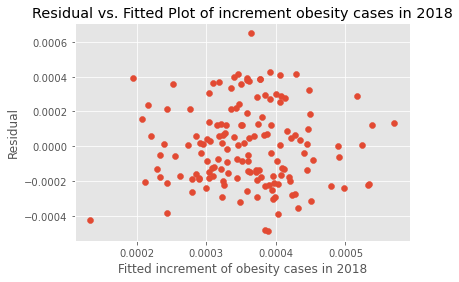

In [112]:
#Residual Analysis

# plot 
plt.scatter(model_obesity_cases_outliers.fittedvalues, model_obesity_cases_outliers.resid)
# adding title and labels
plt.xlabel('Fitted increment of obesity cases in 2018')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of increment obesity cases in 2018')
plt.show()

## Now we know that clean air shouldn't have any impact on the amount of obesity cases, lets drop it to see if this will alter any of our findings.

In [137]:
obesity_cases_final_outliers_clean_air = obesity_cases_outliers.drop(['local_authority_area', '2008_cases_total', '2018_cases_total', '2008_pop_total', '2018_pop_total', 'avg_population', 'region', 'local_authority_type', 'clean_air', 'total_budget'], axis=1)

# double check the result
obesity_cases_final_outliers_clean_air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   incr_cases        150 non-null    float64
 1   clean_environ     150 non-null    float64
 2   health_training   150 non-null    float64
 3   school_awareness  150 non-null    float64
 4   media_awareness   150 non-null    float64
 5   sub_counselling   150 non-null    float64
dtypes: float64(6)
memory usage: 7.2 KB


In [138]:
# using VIF on the bike_rental dataset
df_predictors_selected_VIF_outliers_clean_air = drop_column_using_vif_(obesity_cases_final_outliers_clean_air.drop('incr_cases', axis=1))
# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF_outliers_clean_air.columns)

The columns remaining after VIF selection are:
Index(['clean_environ', 'health_training', 'school_awareness',
       'media_awareness', 'sub_counselling'],
      dtype='object')


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [139]:
model_obesity_cases_outliers_clean_air = sm.OLS(endog=obesity_cases_final_outliers_clean_air[['incr_cases']], exog=sm.add_constant(df_predictors_selected_VIF_outliers_clean_air)).fit()
model_obesity_cases_outliers_clean_air.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             incr_cases   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     2.623
Date:                Mon, 15 Nov 2021   Prob (F-statistic):             0.0266
Time:                        03:05:40   Log-Likelihood:                 1044.8
No. Observations:                 150   AIC:                            -2078.
Df Residuals:                     144   BIC:                            -2060.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0002      0.000      1.780      0.077   -2.63e-05       0.001
clean_environ        0.0002      0.000      0.744      0.458      -0.000       0.001
health_training     -0.0003      0.001     -0.584      0.560      -0.001       0.001
school_awareness    -0.0004      0.000     -1.171      0.243      -0.001       0.000
media_awareness      0.0013      0.000      2.860      0.005       0.000       0.002
sub_counselling      0.0008      0.001      0.996      0.321      -0.001       0.002
==============================================================================
Omnibus:                        3.192   Durbin-Watson:                   2.114
Prob(Omnibus):                  0.203   Jarque-Bera (JB):                2.992
Skew:                           0.276   Prob(JB):                        0.224
Kurtosis:                       2.584   Cond. No.                         41.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

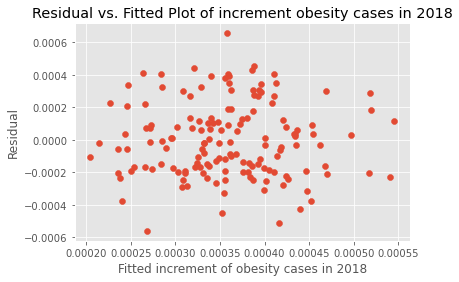

In [140]:
#Residual Analysis

# plot 
plt.scatter(model_obesity_cases_outliers_clean_air.fittedvalues, model_obesity_cases_outliers_clean_air.resid)
# adding title and labels
plt.xlabel('Fitted increment of obesity cases in 2018')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of increment obesity cases in 2018')
plt.show()

When dropping clean_air the total_budget variable does not become redundant or cause multicolinearity because we don't have the sum of all the budget anymore in the variables, which means that we do not drop total_budget when using VIF. This result gives us the same R-squared, meaning that dropping clean_air does not make us lose any information. 